# Mapeamento de Trajetória de Carrinho
**Aruã Viggiano Souza**

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.measure import regionprops, regionprops_table

### Carregando as imagens

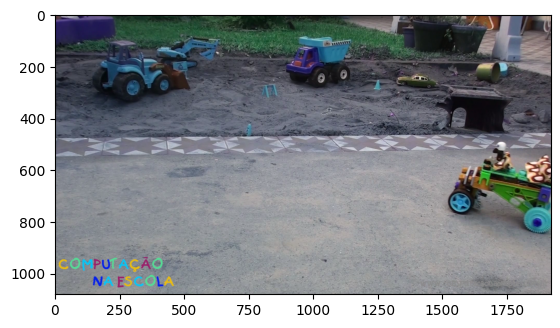

In [2]:
image_names = os.listdir('imagens')
images = [cv2.imread(os.path.join('imagens',name)).astype('int16') for name in image_names]
plt.imshow(images[0])
plt.show()

### Tirando a média das imagens para obter uma imagem de referência

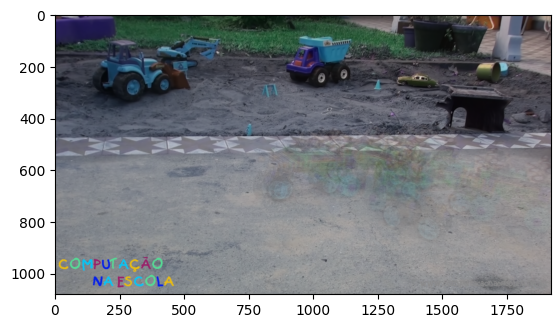

In [3]:
imshape = images[0].shape
mean_img = sum(images) // (np.ones(imshape,dtype = 'int16') * len(images))
plt.imshow(mean_img)
plt.show()

### Calculando a diferença absoluta em relação à imagem de referência

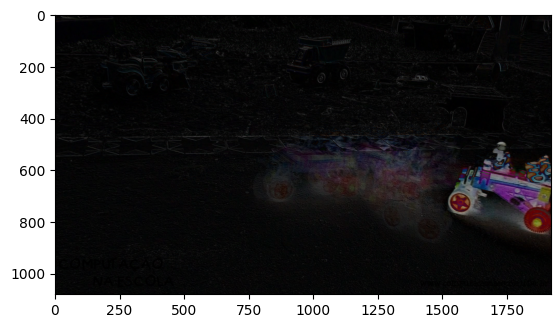

In [4]:
subtracted = [np.abs(img - mean_img) for img in images]
plt.imshow(subtracted[0])
plt.show()

### Convertendo a diferença absoluta para escala de cinza

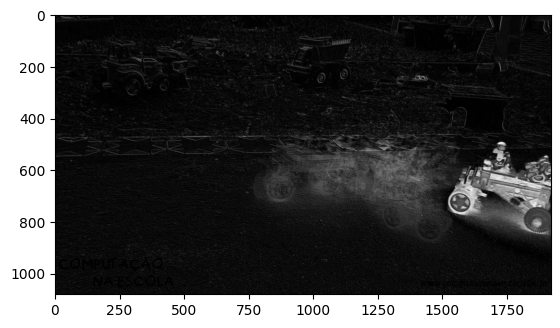

In [5]:
grayscale = [img.mean(axis = 2).astype('int16') for img in subtracted]
plt.imshow(grayscale[0],'gray')
plt.show()

### Aplicando um trashold (percentil de 99%)

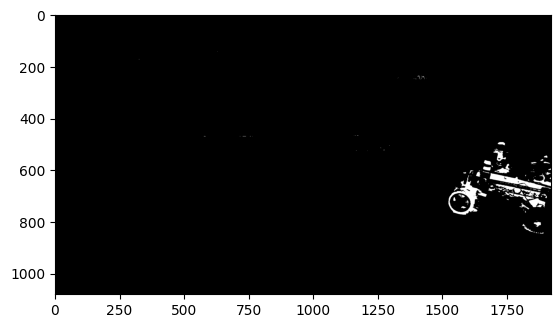

In [6]:
def trashold(img,percentile):
    img = img.copy()
    trash = np.percentile(img.ravel(),percentile)
    img[img > trash] = 255
    img[img <= trash] = 0
    return img

trasholded = [(trashold(img,99)) for img in grayscale]
plt.imshow(trasholded[0],'gray')
plt.show()

### Marcando a posição do carro

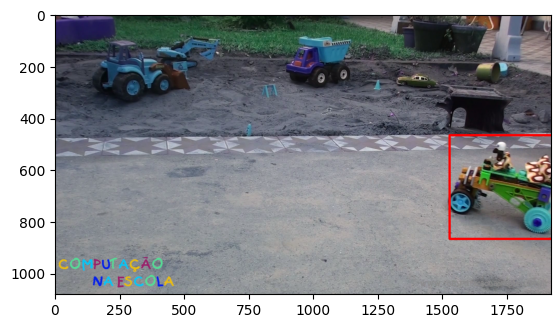

In [18]:
def find_car(img):
    height,width = img.shape
    flat_x = img.sum(axis = 0)
    flat_y = img.sum(axis = 1)
    x = np.ma.average(np.arange(width),weights = flat_x)
    y = np.ma.average(np.arange(height),weights = flat_y)
    return int(x),int(y)

def mark_original_img(original,position):
    original = original.copy()
    size = 200
    x,y = position
    start = x - size,y - size
    end = x + size,y + size
    return cv2.rectangle(original, start, end, (255,0,0), 8)

marked = [mark_original_img(img,find_car(trimg)) for img,trimg in zip(images,trasholded)]
plt.imshow(marked[0])
plt.show()

### Traçando a trajetória

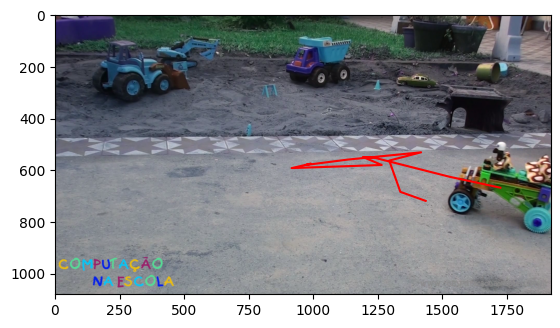

In [9]:
trajetoria = np.array([find_car(img) for img in trasholded])
x,y = trajetoria[:,0],trajetoria[:,1]

fig,ax = plt.subplots()
ax.imshow(images[0])
ax.plot(x,y,color = 'red')
plt.show()

## Criando uma máscara

### Removendo tudo o que não está na região do carrinho

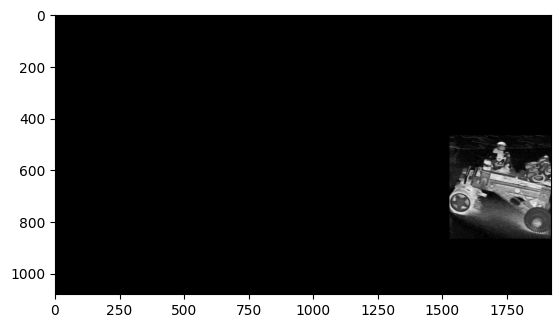

In [8]:
def clean(grayimg,trash_img,space):
    x,y = find_car(trash_img)
    img = grayimg.copy()
    img[y + space:] = 0
    img[:y - space] = 0
    img[:,x + space:] = 0
    img[:,:x - space] = 0
    return img

cleaned = [clean(grayimg,timg,200) for grayimg,timg in zip(grayscale,trasholded)]
plt.imshow(cleaned[0],'gray')
plt.show()

### Aplicando um trashold menor

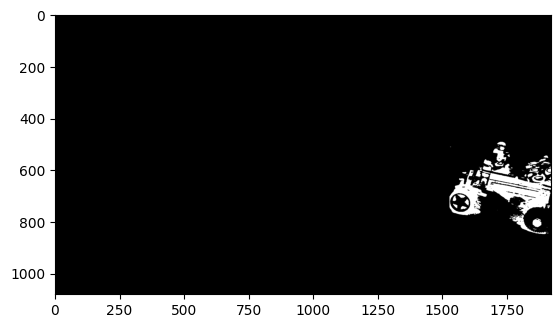

In [9]:
trashmenor = [(trashold(img,98)) for img in cleaned]
plt.imshow(trashmenor[0],'gray')
plt.show()

### Abrindo as máscaras para remover ruído

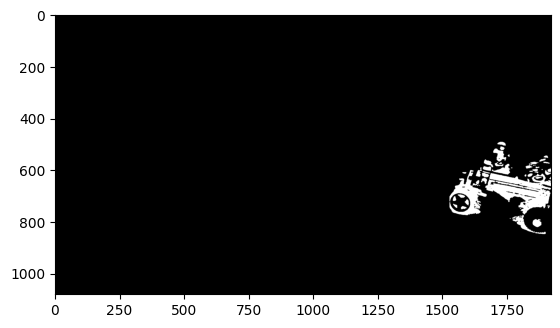

In [10]:
kernel = np.ones((3,3))
opened = [cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) for img in trashmenor]
plt.imshow(opened[0],'gray')
plt.show()

### Fechando as máscaras

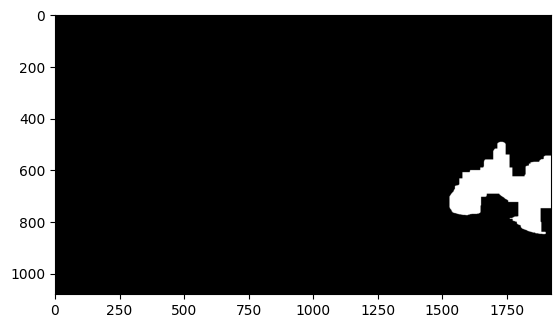

In [11]:
kernel = np.ones((45,45))
closed = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in opened]
plt.imshow(closed[0],'gray')
plt.show()

### Identificando altura, largura e centro do carrinho

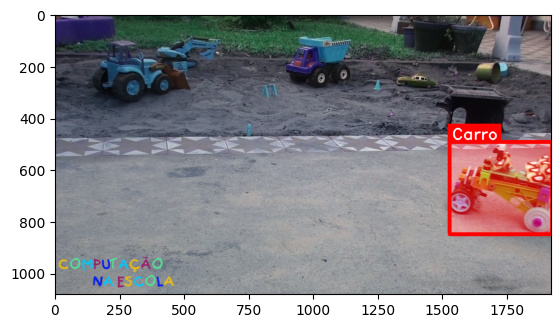

In [67]:
def get_car_stats(mask):
    stats = regionprops(mask)
    return max(stats,key = lambda x: x['area'])

def rectangle_on_image(image,stats):
    thick = 14
    fonte = 2
    alpha = .3
    image = image.copy()
    miny,minx,maxy,maxx = stats.bbox
    image = cv2.rectangle(image,(minx,miny),(maxx,maxy),(255,0,0),thick)
    shapes = np.zeros_like(image,dtype = 'int16')
    shapes = cv2.rectangle(shapes,(minx,miny),(maxx,maxy),(255,0,0),-1)
    mask = shapes.astype(bool)
    image[mask] = cv2.addWeighted(image,alpha,shapes,1 - alpha,0)[mask]
    label_start,label_end = (minx - thick // 2,miny),(minx + 200,miny - 70)
    image = cv2.rectangle(image,label_start,label_end,(255,0,0),-1)
    image = cv2.putText(image,'Carro',(minx + 10,miny-10),fonte,2,(255,255,255),3)
    return image

drawed = [rectangle_on_image(img,get_car_stats(mask)) for img,mask in zip(images,closed)]
plt.imshow(drawed[0])
plt.show()

### Visualisando o resultado

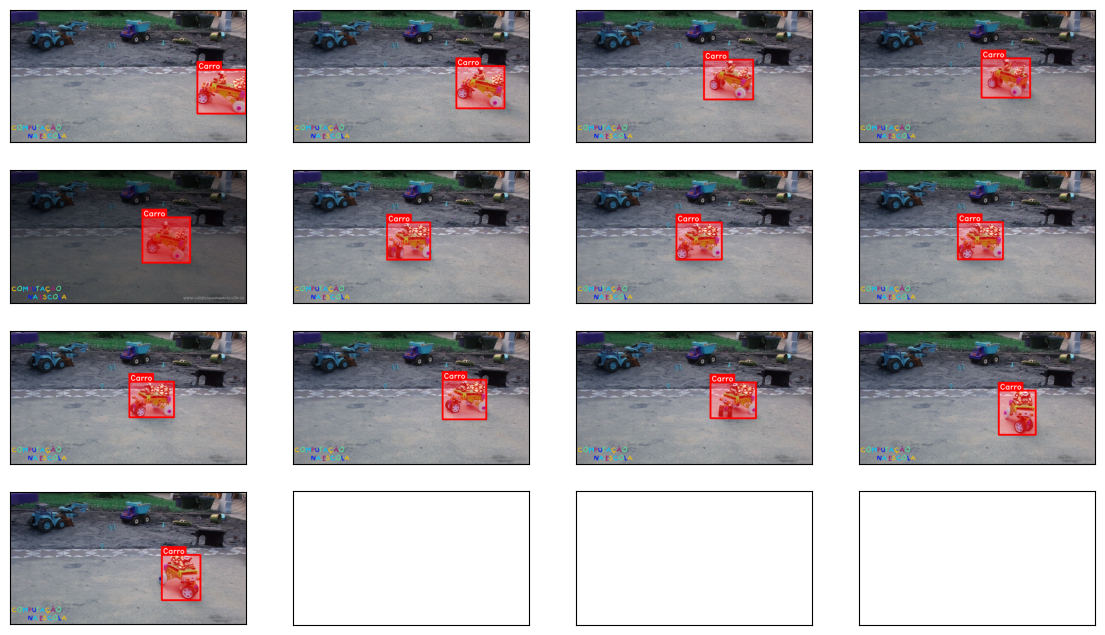

In [68]:
fig,ax = plt.subplots(nrows = 4,ncols = 4,figsize = (14,8))
ax = ax.flatten()
for i,img in enumerate(drawed):
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i in range(13,16):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()